In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy import sparse

%matplotlib inline

# Лабораторная работа 2

### Методы решения СЛАУ

- Метод Гаусса с выбором главного элемента

- Метод $LU$-разложение

- Метод Якоби

- Метод Зейделя

- Метод верхней релаксации

- Метод градиентного спуска

- Метод минимальных невязок

- Стабилизированный метод бисопряженных градиентов

### Используемые нормы

#### Норма 1

$
\begin{align}
    ||\boldsymbol{u}||_1 = \max_{1 \leq i \leq n} |\boldsymbol{u}_i|,
\end{align}
$

$
\begin{align}
    ||\boldsymbol{A}||_1 = \max_{1 \leq i \leq n} \sum_{j = 1}^n |a_{ij}|.
\end{align}
$

#### Норма 2

$
\begin{align}
    ||\boldsymbol{u}||_2 = \sum_{j = 1}^n |\boldsymbol{u}_i|,
\end{align}
$

$
\begin{align}
    ||\boldsymbol{A}||_2 = \max_{1 \leq j \leq n} \sum_{i = 1}^n |a_{ij}|.
\end{align}
$

#### Норма 3

$
\begin{align}
    ||\boldsymbol{u}||_3 = \sqrt{(\boldsymbol{u}, \boldsymbol{u})},
\end{align}
$

$
\begin{align}
    ||\boldsymbol{A}||_3 = \sqrt{\max_{1 \leq i \leq n} \lambda_i (\boldsymbol{A^*} \cdot \boldsymbol{A})}.
\end{align}
$

### Решаемая СЛАУ

**о)** $n = 100, a = b = 10$

$
\begin{align}
    \begin{cases}
        ax_1 + x_2 + x_3/b = 1 \\
        x_1 + ax_2 + x_3 + x_4/b = 2 \\
        x_2 + ax_3 + x_4 + x_5/b = 5 \\
        \dots \\
        x_{m-1} + ax_m + x_{m + 1} + x_{m + 2}/b = m \\
        \dots \\
        x_{n - 2} + ax_{n - 1} + x_n = n - 1 \\
        x_{n - 1} + ax_n = n \\
    \end{cases}
\end{align}
$ 

In [3]:
class Norm:
    def __init__(self, norm, name):
        self.norm = norm
        self.name = name

In [4]:
def norm_1(x):
    return np.linalg.norm(x, ord = np.inf)

def norm_2(x):
    return np.linalg.norm(x, ord = 1)

def norm_3(x):
    return np.linalg.norm(x, ord = 2)

### Генерация матрицы и вектора правой части

In [6]:
e = 1e-6

n = 100
a, b = 10, 10

A = np.array([max(0, m-1) * [0] + int(m > 0) * [1] + [a] + int(m+1 < n) * [1] + int(m+2 < n) * [1] + max(n-m-3, 0) * [0] for m in range(n)],
             dtype=float)
f = np.arange(1, n+1, dtype=float)

norms = [Norm(norm_1, "Norm 1"), Norm(norm_2, "Norm 2"), Norm(norm_3, "Norm 3")]

### Метод Гаусса с выбором главного элемента

In [8]:
def swap_rows(A, f, i, j):
    A[[i, j]] = A[[j, i]]
    f[i], f[j] = f[j], f[i]

def swap_columns(A, pos, i, j):
    A = A.T
    A[[i, j]] = A[[j, i]]
    A = A.T
    pos[i], pos[j] = pos[j], pos[i]

def pivoting(A, f, pos, i, j, e, n):
    pivot = A[i, j]
    k_pivot, l_pivot = i, j
    
    for k in range(i, n):
        for l in range(j, n):
            if np.abs(A[k, l]) > np.abs(pivot):
                pivot = A[k, l]
                k_pivot, l_pivot = k, l

    if np.abs(pivot) < e:
        raise RuntimeError("Cannot find a pivot")

    if i != k_pivot:
        swap_rows(A, f, i, k_pivot)
    if j != l_pivot:
        swap_columns(A, pos, j, l_pivot)

def gauss(A_, f_, e, n):
    A = A_.copy()
    f = f_.copy()
    pos = np.arange(0, n, dtype=int)
    x = np.zeros(n, dtype=float)
    
    for k in range(n - 1):
        pivoting(A, f, pos, k, k, e, n)

        for i in range(k+1, n):
            t = A[i, k] / A[k, k]
            f[i] -= t * f[k]

            for j in range(k+1, n):
                A[i, j] -= t * A[k, j]

    x[n-1] = f[n-1] / A[n-1, n-1]
    for k in range(n-2, -1, -1):
        subtract = 0.0
        for j in range(k+1, n):
            subtract += A[k, j] * x[j]

        x[k] = (f[k] - subtract) / A[k, k]

    ans = np.zeros(n, dtype=float)
    for i in range(n):
        ans[pos[i]] = x[i]
    return ans

x = gauss(A, f, e, n)

for norm in norms:
    print(f"Residual of Gaussian elimination in {norm.name}: {norm.norm(f-A.dot(x))}")

Residual of Gaussian elimination in Norm 1: 2.842170943040401e-14
Residual of Gaussian elimination in Norm 2: 4.731770530952417e-13
Residual of Gaussian elimination in Norm 3: 9.0221452849805e-14


### $LU$-разложение

In [10]:
def check_LU(A, e, n):
    for i in range(n):
        if np.abs(np.linalg.det(A[:i, :i])) < e:
            return False
    
    return True

def LU_decomposition(A_, e, n):
    A = A_.copy()

    for i in range(1, n):
        for k in range(i):
            A[i, k] /= A[k, k]

            for j in range(k+1, n):
                A[i, j] -= A[i, k] * A[k, j]

    L = np.eye(n, dtype=float)
    for i in range(n):
        for j in range(i):
            L[i, j] = A[i, j]

    U = np.zeros_like(A)
    for i in range(n):
        for j in range(i, n):
            U[i, j] = A[i, j]

    return L, U

def LU_solution(L_, U_, f_, n):
    L, U, f = L_.copy(), U_.copy(), f_.copy() 
    x, y = np.zeros(n, dtype=float), np.zeros(n, dtype=float)

    for i in range(n):
        subtract = 0.0
        for k in range(i):
            subtract += L[i, k] * y[k]
        y[i] = f[i] - subtract

    for i in range(n-1, -1, -1):
        subtract = 0.0
        for k in range(i+1, n):
            subtract += U[i, k] * x[k]
        x[i] = (y[i] - subtract) / U[i, i]

    return x
    
if check_LU(A, e, n):
    L, U = LU_decomposition(A, e, n)

    x = LU_solution(L, U, f, n)
    for norm in norms:
        print(f"Residual of LU-decomposition in {norm.name}: {norm.norm(f-A.dot(x))}")

Residual of LU-decomposition in Norm 1: 1.4210854715202004e-14
Residual of LU-decomposition in Norm 2: 3.9879211044535623e-13
Residual of LU-decomposition in Norm 3: 6.862004622021337e-14


### Метод Якоби

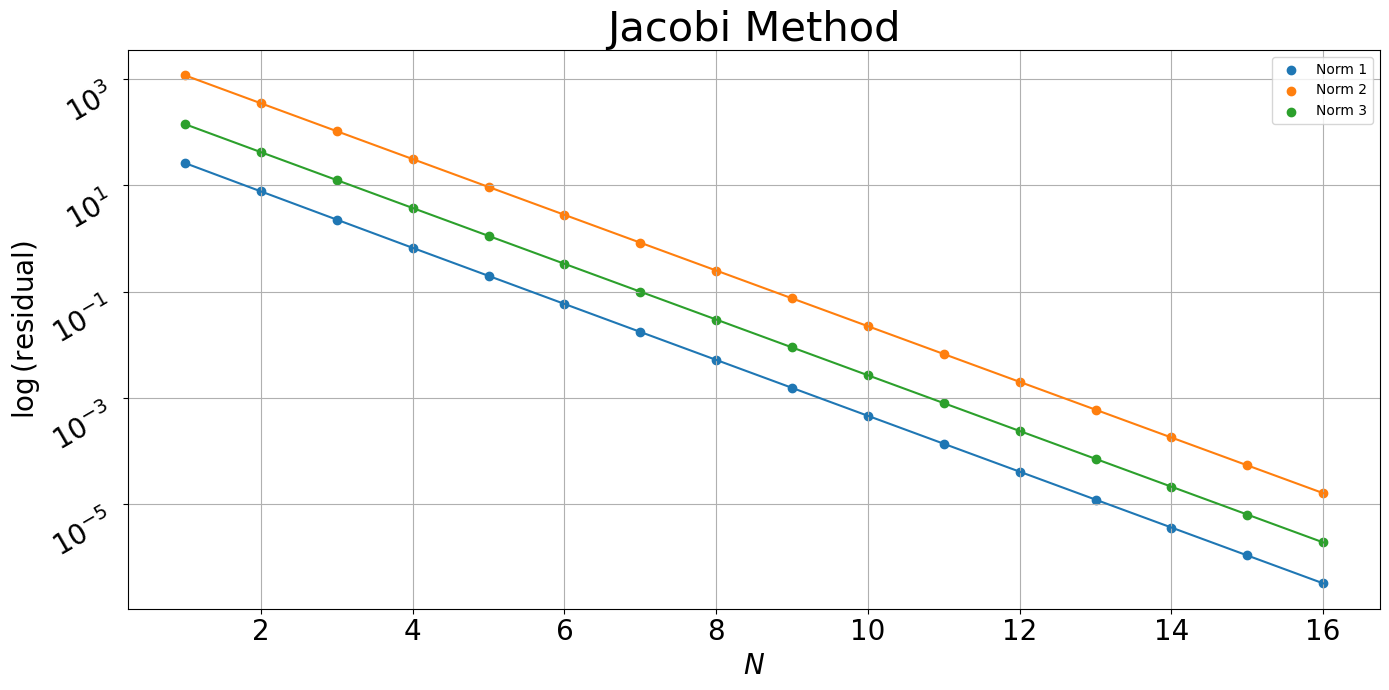

In [12]:
def jacobi(A, f, x_0, e, n):
    x = x_0.copy()
    residuals_1, residuals_2, residuals_3 = [], [], []
    
    while(min(norm_1(f - A.dot(x)), norm_2(f - A.dot(x)), norm_3(f - A.dot(x))) > e):
        y = np.zeros(n)
        for i in range(n):
            for j in range(i):
                y[i] += A[i, j] * x[j]
            for j in range(i+1, n):
                y[i] += A[i, j] * x[j]

            y[i] = (f[i] - y[i]) / A[i, i]
        x = y

        residuals_1.append(norm_1(f - A.dot(x)))
        residuals_2.append(norm_2(f - A.dot(x)))
        residuals_3.append(norm_3(f - A.dot(x)))

    return x, residuals_1, residuals_2, residuals_3

x_0 = np.ones(n)
x, residuals_1, residuals_2, residuals_3 = jacobi(A, f, x_0, e, n)
residuals = np.array([np.array(residuals_1), np.array(residuals_2), np.array(residuals_3)])

iterations = np.arange(1, residuals[0].size + 1)

plt.figure(figsize=[14, 7])
plt.title("Jacobi Method", fontsize=30)

plt.yscale("log")

plt.xlabel('$N$', fontsize = 20)
plt.xticks (fontsize = 20, ha = "center", va = "top")

plt.ylabel("$\\log{(\\text{residual})}$", fontsize = 20)
plt.yticks (fontsize = 20, rotation = 30, ha = "right", va = "top")

plt.grid(which = "both")

for residual, norm in zip(residuals, norms):
    plt.scatter(iterations, residual, label=norm.name)
    plt.plot(iterations, residual)
    plt.legend(loc = "best")
    plt.tight_layout()

### Метод Зейделя

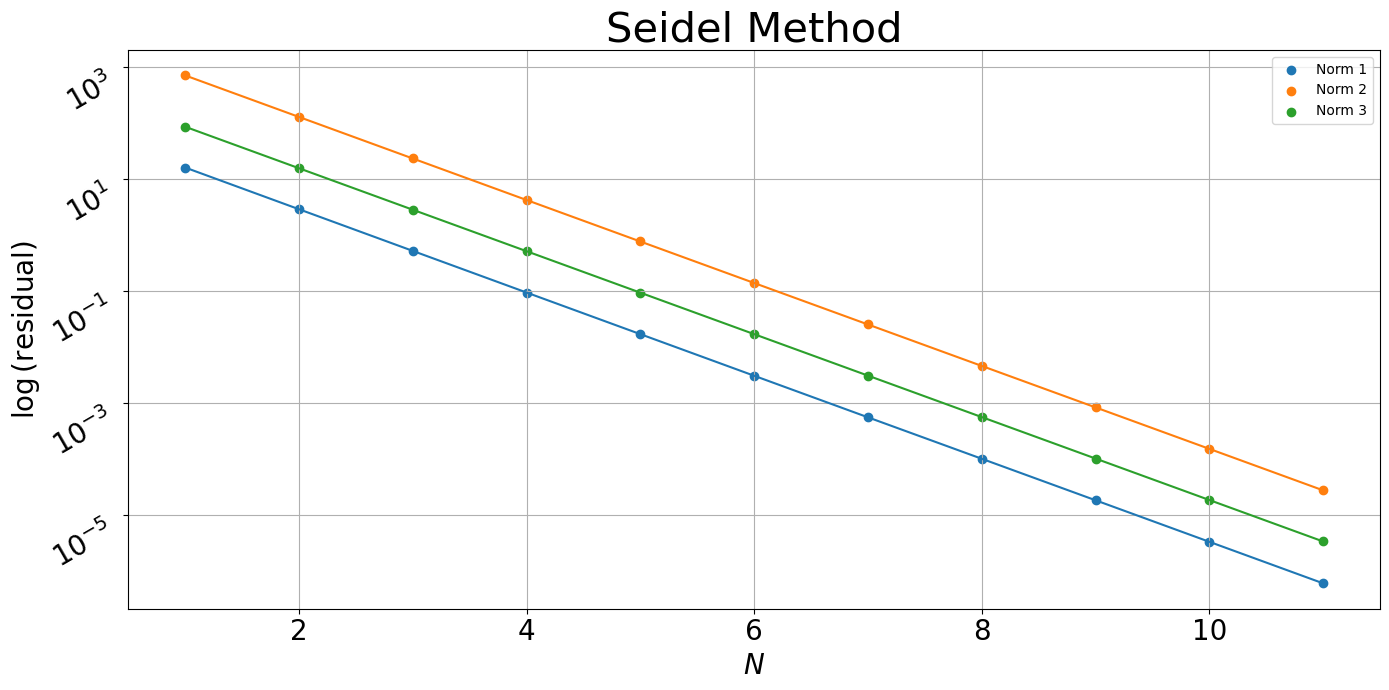

In [14]:
def seidel(A, f, x_0, e, n):
    x = x_0.copy()
    residuals_1, residuals_2, residuals_3 = [], [], []
    
    while(min(norm_1(f - A.dot(x)), norm_2(f - A.dot(x)), norm_3(f - A.dot(x))) > e):
        y = np.zeros(n)
        for i in range(n):
            sigma = 0.0
            for j in range(i):
                sigma += A[i, j] * y[j]
            for j in range(i+1, n):
                sigma += A[i, j] * x[j]
            
            y[i] = (f[i] - sigma) / A[i, i]
        x = y

        residuals_1.append(norm_1(f - A.dot(x)))
        residuals_2.append(norm_2(f - A.dot(x)))
        residuals_3.append(norm_3(f - A.dot(x)))

    return x, residuals_1, residuals_2, residuals_3

x_0 = np.ones(n)
x, residuals_1, residuals_2, residuals_3 = seidel(A, f, x_0, e, n)
residuals = np.array([np.array(residuals_1), np.array(residuals_2), np.array(residuals_3)])

iterations = np.arange(1, residuals[0].size + 1)

plt.figure(figsize=[14, 7])
plt.title("Seidel Method", fontsize=30)

plt.yscale("log")

plt.xlabel('$N$', fontsize = 20)
plt.xticks (fontsize = 20, ha = "center", va = "top")

plt.ylabel("$\\log{(\\text{residual})}$", fontsize = 20)
plt.yticks (fontsize = 20, rotation = 30, ha = "right", va = "top")

plt.grid(which = "both")

for residual, norm in zip(residuals, norms):
    plt.scatter(iterations, residual, label=norm.name)
    plt.plot(iterations, residual)
    plt.legend(loc = "best")
    plt.tight_layout()

###  Метод верхней релаксации

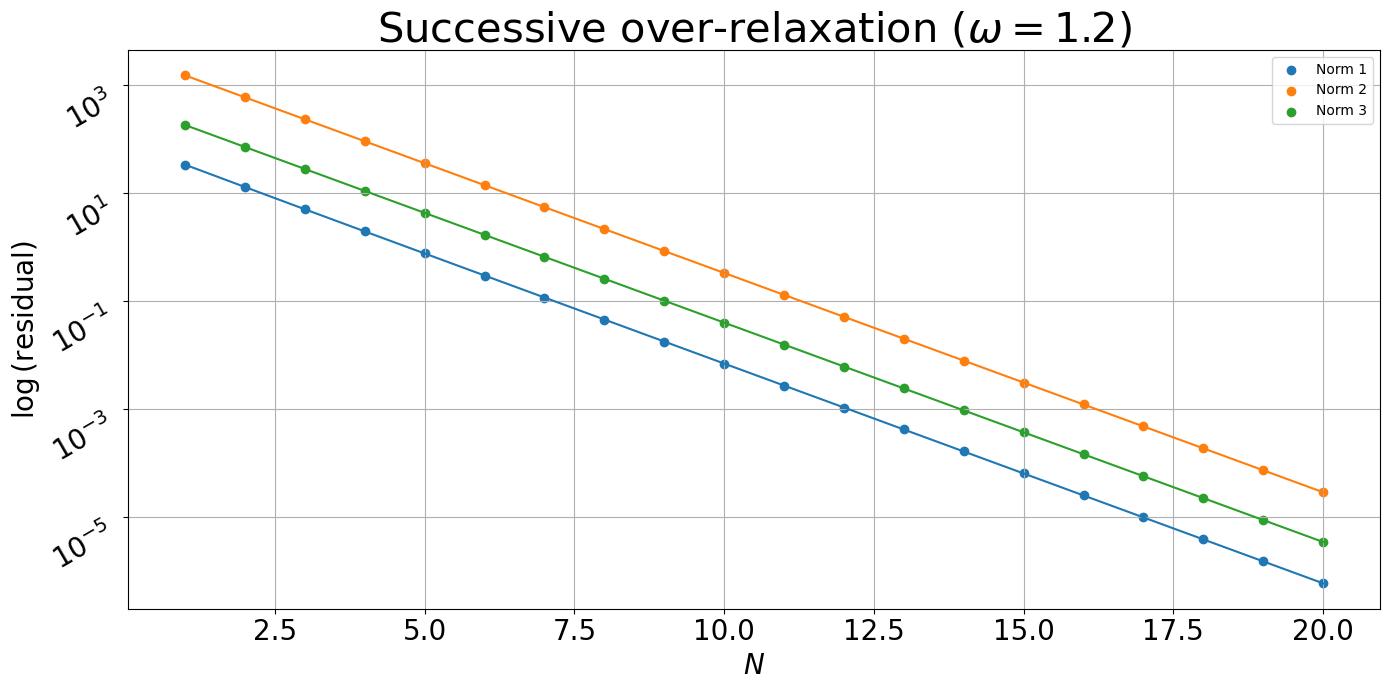

In [16]:
def SOR(A, f, x_0, w, e, n):
    x = x_0.copy()
    residuals_1, residuals_2, residuals_3 = [], [], []
    
    while(min(norm_1(f - A.dot(x)), norm_2(f - A.dot(x)), norm_3(f - A.dot(x))) > e):
        y = np.zeros(n)
        for i in range(n):
            sigma = 0.0
            for j in range(i):
                sigma += A[i, j] * y[j]
            for j in range(i+1, n):
                sigma += A[i, j] * x[j]

            sigma = (f[i] - sigma) / A[i, i]
            y[i] = x[i] + w * (sigma - x[i])
        x = y

        residuals_1.append(norm_1(f - A.dot(x)))
        residuals_2.append(norm_2(f - A.dot(x)))
        residuals_3.append(norm_3(f - A.dot(x)))

    return x, residuals_1, residuals_2, residuals_3

w = 1.2
x_0 = np.ones(n)
x, residuals_1, residuals_2, residuals_3 = SOR(A, f, x_0, w, e, n)
residuals = np.array([np.array(residuals_1), np.array(residuals_2), np.array(residuals_3)])

iterations = np.arange(1, residuals[0].size + 1)

plt.figure(figsize=[14, 7])
plt.title("Successive over-relaxation ($\\omega = 1.2$)", fontsize=30)

plt.yscale("log")

plt.xlabel('$N$', fontsize = 20)
plt.xticks (fontsize = 20, ha = "center", va = "top")

plt.ylabel("$\\log{(\\text{residual})}$", fontsize = 20)
plt.yticks (fontsize = 20, rotation = 30, ha = "right", va = "top")

plt.grid(which = "both")

for residual, norm in zip(residuals, norms):
    plt.scatter(iterations, residual, label=norm.name)
    plt.plot(iterations, residual)
    plt.legend(loc = "best")
    plt.tight_layout()

### Метод наискорейшего спуска

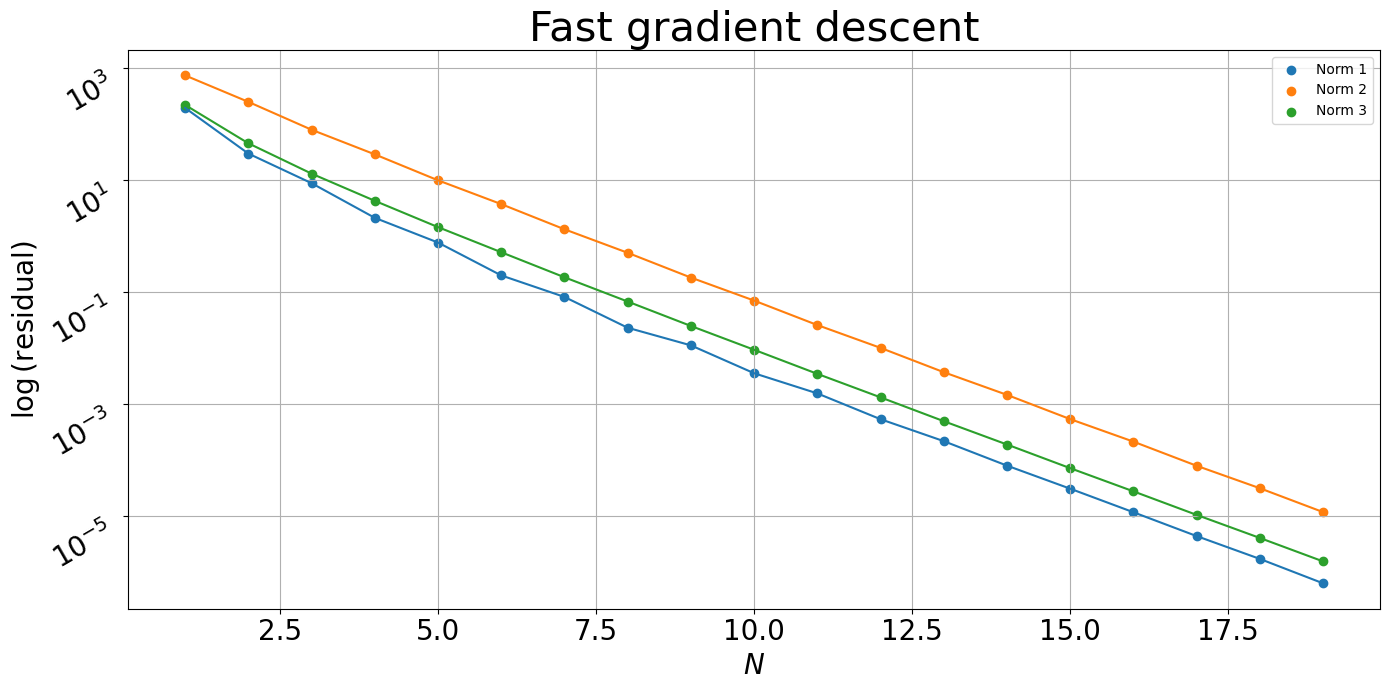

In [18]:
def FGD(A_, f_, x_0, e):
    A = A_.T @ A_
    f = A_.T.dot(f_)
    x = x_0.copy()
    residuals_1, residuals_2, residuals_3 = [], [], []
    
    while(min(norm_1(f - A.dot(x)), norm_2(f - A.dot(x)), norm_3(f - A.dot(x))) > e):
        tau = (A.dot(x) - f).dot(A.dot(x) - f) / (A.dot(A.dot(x) - f)).dot(A.dot(x) - f)
        x -= tau * (A.dot(x) - f)

        residuals_1.append(norm_1(f - A.dot(x)))
        residuals_2.append(norm_2(f - A.dot(x)))
        residuals_3.append(norm_3(f - A.dot(x)))

    return x, residuals_1, residuals_2, residuals_3


x_0 = np.ones(n)
x, residuals_1, residuals_2, residuals_3 = FGD(A, f, x_0, e)
residuals = np.array([np.array(residuals_1), np.array(residuals_2), np.array(residuals_3)])

iterations = np.arange(1, residuals[0].size + 1)

plt.figure(figsize=[14, 7])
plt.title("Fast gradient descent", fontsize=30)

plt.yscale("log")

plt.xlabel('$N$', fontsize = 20)
plt.xticks (fontsize = 20, ha = "center", va = "top")

plt.ylabel("$\\log{(\\text{residual})}$", fontsize = 20)
plt.yticks (fontsize = 20, rotation = 30, ha = "right", va = "top")

plt.grid(which = "both")

for residual, norm in zip(residuals, norms):
    plt.scatter(iterations, residual, label=norm.name)
    plt.plot(iterations, residual)
    plt.legend(loc = "best")
    plt.tight_layout()

### Метод минимальных невязок

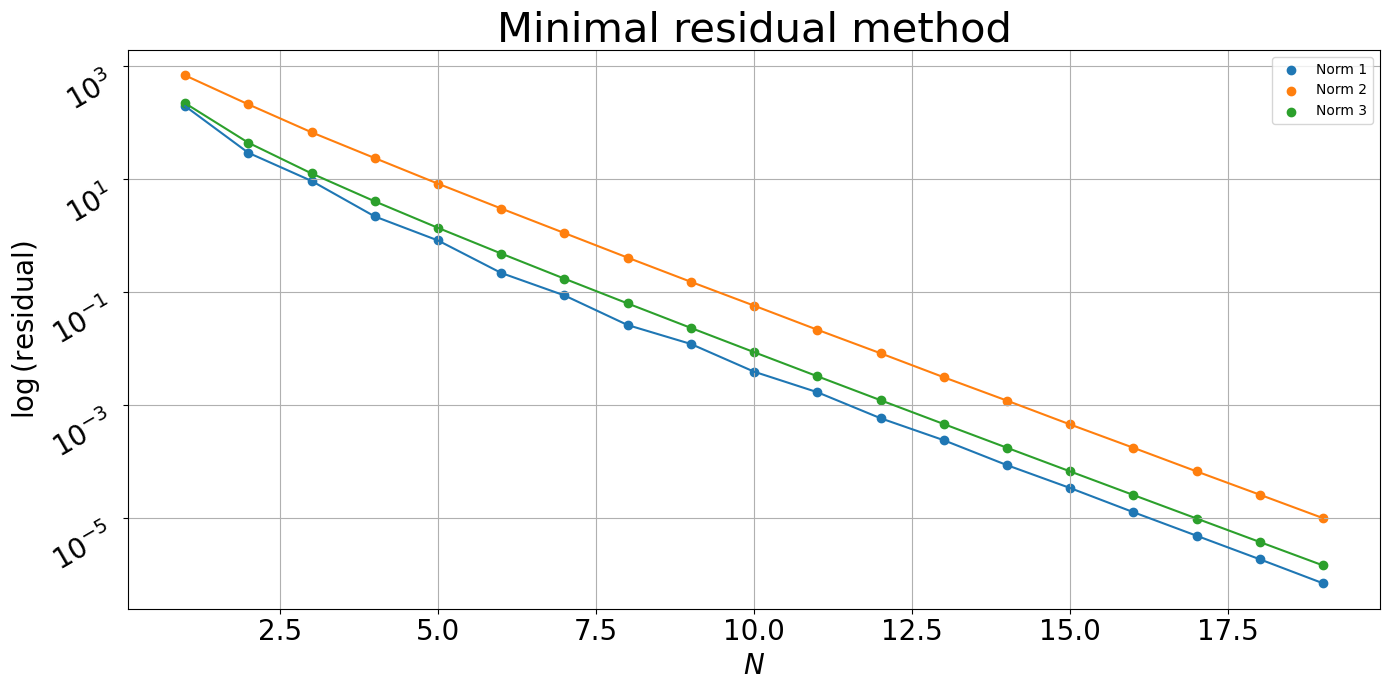

In [52]:
def MRM(A_, f_, x_0, e):
    A = A_.T @ A_
    f = A_.T.dot(f_)
    x = x_0.copy()
    residuals_1, residuals_2, residuals_3 = [], [], []
    
    while(min(norm_1(f - A.dot(x)), norm_2(f - A.dot(x)), norm_3(f - A.dot(x))) > e):
        tau = (A.dot(A.dot(x) - f)).dot(A.dot(x) - f) / (A.dot(A.dot(x) - f)).dot(A.dot(A.dot(x) - f))
        x -= tau * (A.dot(x) - f)

        residuals_1.append(norm_1(f - A.dot(x)))
        residuals_2.append(norm_2(f - A.dot(x)))
        residuals_3.append(norm_3(f - A.dot(x)))

    return x, residuals_1, residuals_2, residuals_3


x_0 = np.ones(n)
x, residuals_1, residuals_2, residuals_3 = MRM(A, f, x_0, e)
residuals = np.array([np.array(residuals_1), np.array(residuals_2), np.array(residuals_3)])

iterations = np.arange(1, residuals[0].size + 1)

plt.figure(figsize=[14, 7])
plt.title("Minimal residual method", fontsize=30)

plt.yscale("log")

plt.xlabel('$N$', fontsize = 20)
plt.xticks (fontsize = 20, ha = "center", va = "top")

plt.ylabel("$\\log{(\\text{residual})}$", fontsize = 20)
plt.yticks (fontsize = 20, rotation = 30, ha = "right", va = "top")

plt.grid(which = "both")

for residual, norm in zip(residuals, norms):
    plt.scatter(iterations, residual, label=norm.name)
    plt.plot(iterations, residual)
    plt.legend(loc = "best")
    plt.tight_layout()

### Стабилизированный метод бисопряжённых градиентов

C:\Users\MSI\AppData\Local\Temp\ipykernel_10704\2094506051.py:2: SparseEfficiencyWarning: spilu converted its input to CSC format
  return sparse.linalg.spilu(A)


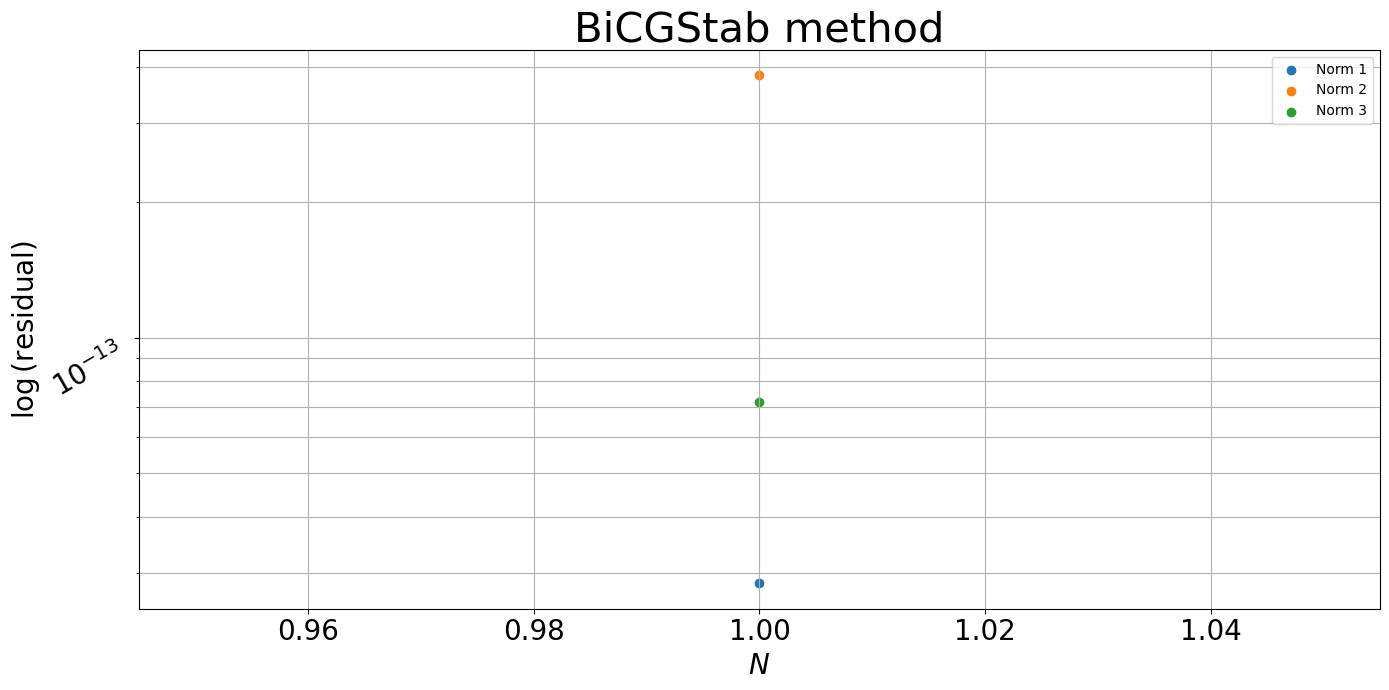

In [55]:
def precondition(A, n):
    return sparse.linalg.spilu(A)

def BiCGStab(A_, f_, x_0, e):
    A = A_.copy()
    f = f_.copy()
    x = x_0.copy()
    M = precondition(A, n)
    print(M)
    residuals_1, residuals_2, residuals_3 = [], [], []

    r_0 = f - A.dot(x)
    r = r_0
    flag = True
    while(min(norm_1(f - A.dot(x)), norm_2(f - A.dot(x)), norm_3(f - A.dot(x))) > e):
        rho = r_0.dot(r)
        if np.abs(rho) < e:
            raise RuntimeError("BiCGStab cannot solve the system")
        if flag:
            p = r
            flag = False
        else:
            beta = (rho / rho_prev) * (alpha / omega)
            p = r - beta * (p - omega * v)

        p_ = M.solve(p)
        v = A.dot(p_)
        alpha = rho / r_0.dot(v)
        s = r - alpha * v
        if norm_3(s) / norm_3(r_0) < e:
            x += alpha * p_
            residuals_1.append(norm_1(f - A.dot(x)))
            residuals_2.append(norm_2(f - A.dot(x)))
            residuals_3.append(norm_3(f - A.dot(x)))
            return x, residuals_1, residuals_2, residuals_3
        
        s_ = M.solve(s)
        t = A.dot(s_)
        omega = t.dot(s) / t.dot(t)
        x += alpha * p_ + omega * s_
        r = s - omega * t
        if norm_3(r) / norm_3(r_0) < e:
            residuals_1.append(norm_1(f - A.dot(x)))
            residuals_2.append(norm_2(f - A.dot(x)))
            residuals_3.append(norm_3(f - A.dot(x)))
            return x, residuals_1, residuals_2, residuals_3

        residuals_1.append(norm_1(f - A.dot(x)))
        residuals_2.append(norm_2(f - A.dot(x)))
        residuals_3.append(norm_3(f - A.dot(x)))

    return x, residuals_1, residuals_2, residuals_3

x_0 = np.ones(n)
x, residuals_1, residuals_2, residuals_3 = BiCGStab(A, f, x_0, e)
residuals = np.array([np.array(residuals_1), np.array(residuals_2), np.array(residuals_3)])

iterations = np.arange(1, residuals[0].size + 1)

plt.figure(figsize=[14, 7])
plt.title("BiCGStab method", fontsize=30)

plt.yscale("log")

plt.xlabel('$N$', fontsize = 20)
plt.xticks (fontsize = 20, ha = "center", va = "top")

plt.ylabel("$\\log{(\\text{residual})}$", fontsize = 20)
plt.yticks (fontsize = 20, rotation = 30, ha = "right", va = "top")

plt.grid(which = "both")

for residual, norm in zip(residuals, norms):
    plt.scatter(iterations, residual, label=norm.name)
    plt.plot(iterations, residual)
    plt.legend(loc = "best")
    plt.tight_layout()